In [1]:
#| default_exp volume
# Diffusion Curvature utils
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.datasets import *
from diffusion_curvature.utils import *
# Python necessities
import numpy as np
from fastcore.all import *
import matplotlib.pyplot as plt
# Notebook Helpers
from nbdev.showdoc import *
from tqdm.notebook import trange, tqdm
%load_ext autoreload
%autoreload 2

# Volume Estimation with Heat Diffusion

> TLDR: The self-diffusion method of volume estimation works reliably in sampled euclidean planes of various dimensions. The volume differs from ground truth by a multiplicative factor, but otherwise grows at the same ratio as analytically expected. Be wary, though, of volumes taken at high diffusion times: they vary wildly between samplings. 

In [GitHub - KrishnaswamyLab/HeatGeo: Embedding with the Heat-geodesic dissimilarity](https://github.com/KrishnaswamyLab/HeatGeo), Tong et al use the Chebyshev approximation of the heat equation on the graph to estimate volume, by using Varadhan's formula:

$$
\frac{c(\epsilon)}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{4(1+\epsilon) t}\right) \leq h_t(x, y) \leq \frac{C(\epsilon)}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{4(1-\epsilon) t}\right)
$$

This suggests that the diagonals of the diffusion matrix ($h_t(x,x)$) approximate $\frac{1}{V(x,\sqrt{t})}$. To recover the volume, invert the 'laziness' of the diffusion.

Note that the diffusion times correspond only to the square root of the radius.

In this notebook, we'll implement and experiment on this method of volume estimation, by performing it on several manifolds where the volume is known.

In [2]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.graphs import *
X, ks = torus(2000)
G_torus = get_alpha_decay_graph(X)

In [3]:
#| export
import numpy as np
from diffusion_curvature.utils import kronecker_delta
from diffusion_curvature.heatkernel import expm_multiply, heat_diffusion_on_signal
def volume_via_heat_at_scales(
    G, # a pygsp graph 
    idx, # index of point to grow ball from. If none, returns sequence of volumes for every idx.
    ts, # list of times (or single time). 
    denoising_scale = 5, # if nonzero, denoises the heat estimate by replacing with the expected value of heat measured against a diffusion with t=denoising_scale
):
    """
    Returns a list of volumes of the t-step balls constructed at point i, for each t in ts.
    If idx=None, returns a matrix where each row is as above.
    """
    n = G.L.shape[0]
    x = kronecker_delta(n,idx)
    if denoising_scale > 0: # replace h_t(i,i) with its expected value, measured against the first diffusion
        ts_with_denoising = np.concatenate([[denoising_scale],np.array(ts)])
        diffused_at_scales = heat_diffusion_on_signal(G,np.eye(n), ts_with_denoising) # each signal is a row
        diffused_at_scales = np.array(diffused_at_scales) # a 3d array of shape num ts x n x n
        if idx is None:
            denoising_distribution = diffused_at_scales[0].T
        else:
            denoising_distribution = diffused_at_scales[0][idx].T
        # get diagonals of each second dimension
        diagonals_of_diffusion = np.array([np.diag(D) for D in diffused_at_scales[1:]])
        # take expected value according to ith idx # TODO: For multi-point diffusion, just repeat this for several idx
        diffused_denoised = diagonals_of_diffusion @ denoising_distribution
        diffused_denoised = diffused_denoised.T
        volumes = 1 / diffused_denoised
        # print("using denoising",denoising_scale)
    else:
        diffused_at_scales = heat_diffusion_on_signal(G,x, ts) # each signal is a row
        diffused_at_scales = np.array(diffused_at_scales)
        volumes = 1/diffused_at_scales[:,idx] # the ith column has the self affinities
    return volumes

In [4]:
volumes_on_torus = volume_via_heat_at_scales(G_torus,0,[2,4,6,8],denoising_scale=3)
volumes_on_torus

array([15.50544602, 26.22544617, 36.36346207, 46.74038238])

In [5]:
d_stuff = np.array(heat_diffusion_on_signal(G_torus,np.eye(len(X)),[5,7,9]))

In [6]:
d_stuff.shape

(3, 967, 967)

# Correcting for the time-delay of a discrete dirac

You'll notice a peculiar feature of our volume estimation formula. As ${} t \to 0$, our volume estimate ${} \frac{1}{h(x,\sqrt{ t })} \to 1 {}$. This is due to the nature of the dirac we’re diffusing from $x$. 

In the continuous, analytic case, this dirac places infinite mass at x, but in our discrete approximation (where x is one of a finite number of points), we compromise by putting a mass of $1$ at $x$ when $t$ is 0. The result: the smallest possible volume is $1$. There’s an offset between $t$ and $r$ which goes beyond multiplicative scaling, and makes quadratic fitting much harder.

How to overcome this?

We can model this offset via the equation ${} r= a\sqrt{ t } + b {}$; this simply expresses that t=0 corresponds to some nonzero radius, and one step of time may cover $a$ units of distance. Thus, to find the offset $b$, we need to figure out what radius corresponds to $t=0$: when is the analytic volume equal to 1? Solving this gives us $b$‘s value.

In [8]:
#|export
from sympy import Symbol, pi, solve
from scipy.special import gamma
import numpy as np

def calculate_radius_offset(n):
    r = Symbol('r')  # radius of the n-sphere
    V = (pi**(n/2) / (gamma(n/2 + 1))) * r**n  # formula for the volume of an n-sphere
    # Solve for radius r when V = 1
    radius_solution = solve(V - 1, r)
    if radius_solution:
        return np.abs(radius_solution[0].evalf())  # return the numerical value of the radius
    else:
        return None  # no solution found

Using this calculated offset, we can more accurately convert between $t$ and $r$.

In [9]:
def convert_t_to_r(ts, dim):
    return np.sqrt(ts) + calculate_radius_offset(dim)

# Experiments

## Volume in the ND Euclidean Plane, compared to the actual volume

This is the simplest case. We'll sample euclidean planes of several dimensions, and take volume estimates at various scales. We'll compare those to the real volumes of balls of radii $\sqrt{t}$, by plotting one against the other. 

I suspect that there will be some scaling factor which needs to be estimated, as -- just from the graph -- we don't know what the density is.

In [10]:
from diffusion_curvature.datasets import plane
def volumes_of_euclidean_nplane(
        n_points,
        dim,
        ts,
        decay=40,
        knn=10,
        anisotropy=0,
        denoising_scale = 0,
):
    X = plane(n_points,dim)
    G = get_alpha_decay_graph(X, knn=knn, decay=decay, anisotropy=anisotropy)
    vols = volume_via_heat_at_scales(G,0,ts, denoising_scale=denoising_scale)
    return vols

In [11]:
#| export
from scipy.special import gamma
def actual_euclidean_volumes_at_radii(
        dim,
        radii
):
    vols = []
    for r in radii:
        v = np.pi**(dim/2)/(gamma(dim/2+1))*r**dim
        vols.append(v)
    return np.array(vols)

In [12]:
assert actual_euclidean_volumes_at_radii(2,[4]) == np.pi*4**2

In [13]:
def perform_trials(fn,n_trials=10, **kwargs):
    outs = []
    for i in range(n_trials):
        outs.append(fn(**kwargs))
    return outs

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_arrays(estimated, actual, xs=None, title=""):
    sns.set(style="darkgrid")  # Set the seaborn style

    # Create a figure and axes
    fig, ax = plt.subplots()

    if estimated.shape[0] > 1:
        # Compute the mean and standard deviation for the estimated array
        mean_estimated = np.mean(estimated, axis=0)
        std_estimated = np.std(estimated, axis=0)

        # Plot estimated as a line with error bars
        ax.errorbar(x = xs, y = mean_estimated, yerr=std_estimated, label="Estimated")
    else:
        ax.plot(xs, estimated[0], label="Estimated")
    # Plot actual as a line
    ax.plot(xs, actual, label="Actual")

    # Set the labels for x-axis and y-axis
    ax.set_xlabel("Radius")
    ax.set_ylabel("Volume of n-sphere")

    # Set the title of the plot
    ax.set_title(title)

    # Display the legend
    ax.legend()

    # Show the plot
    plt.show()

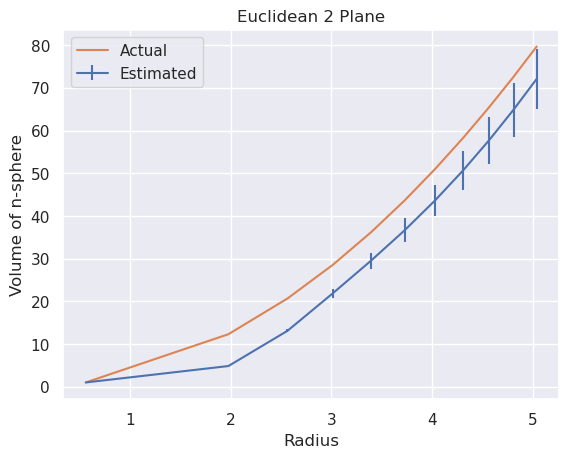

In [26]:
ts = [0,2,4,6,8,10,12,14,16,18,20]
dim = 2
n_points=1000
knn=10
decay=20
anisotropy=0.5
radii = convert_t_to_r(ts,dim)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts, knn=knn, anisotropy=anisotropy, decay=decay, denoising_scale=3)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,xs=radii,title="Euclidean 2 Plane")


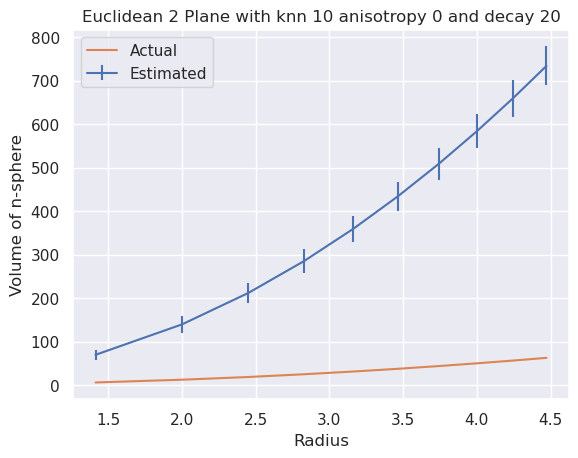

In [16]:
ts = [2,4,6,8,10,12,14,16,18,20]
knn=10
decay=20
anisotropy=0
dim = 2
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts, knn=knn, anisotropy=anisotropy, decay=decay)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,xs = radii, title=f"Euclidean 2 Plane with knn {knn} anisotropy {anisotropy} and decay {decay}")


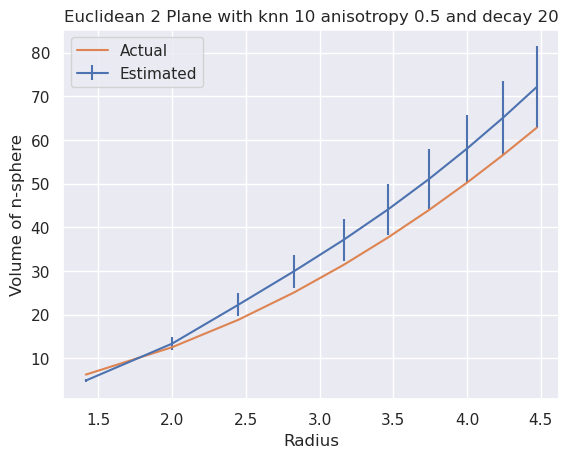

In [17]:
ts = [2,4,6,8,10,12,14,16,18,20]
knn=10
decay=20
anisotropy=0.5
dim = 2
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts, knn=knn, anisotropy=anisotropy, decay=decay)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,xs=radii, title=f"Euclidean 2 Plane with knn {knn} anisotropy {anisotropy} and decay {decay}")


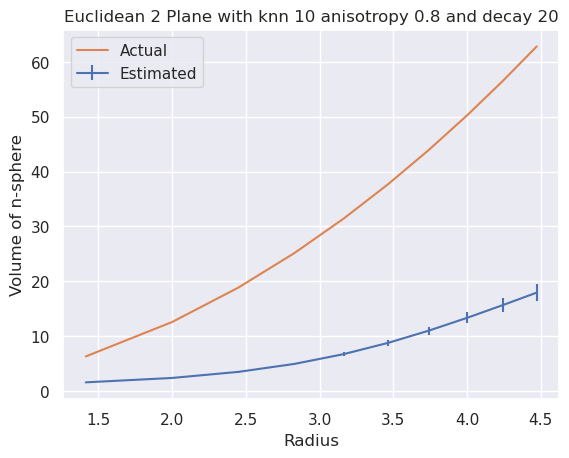

In [18]:
ts = [2,4,6,8,10,12,14,16,18,20]
knn=10
decay=20
anisotropy=0.8
dim = 2
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts, knn=knn, anisotropy=anisotropy, decay=decay)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,xs=radii,title=f"Euclidean 2 Plane with knn {knn} anisotropy {anisotropy} and decay {decay}")


This shows a clear pattern: the volume estimated from residual laziness has 
1. a lot of variation across samplings, especially with higher t values
2. a consistently higher slope than the ground truth, by a constant multiple. 

The second point is consistent with the hypothesis that the unknown density of the graph/point cloud results in a distortion of the volume by some constant factor. Fortunately, when performing a comparison between the manifold space and analytic euclidean space, this factor becomes a constant, reflected only in the linear term of the quadratic approximation, and not in the quadratic term, where scalar curvature is revealed.

The first phenomenon, of increasing variation with increasing radius, is odd. One might expect that large-scale diffusions had the *least* variation between samplings, because it has more time for local fluctuations in density to average out. The opposite appears to be true. At least this supports the use of local approximations.

Let's see what the ratio actually is:

In [19]:
def plot_array(ratios, title=""):
    sns.set(style="darkgrid")  # Set the seaborn style

    # Create a figure and axes
    fig, ax = plt.subplots()
    # Compute the mean and standard deviation for the estimated array
    mean_estimated = np.mean(ratios, axis=0)
    std_estimated = np.std(ratios, axis=0)

    # Plot estimated as a line with error bars
    ax.errorbar(np.arange(ratios.shape[1]), mean_estimated, yerr=std_estimated, label="Estimated")

    # Set the labels for x-axis and y-axis
    ax.set_xlabel("Radius")
    ax.set_ylabel("Volume of n-sphere")

    # Set the title of the plot
    ax.set_title(title)

    # Display the legend
    ax.legend()

    # Show the plot
    plt.show()

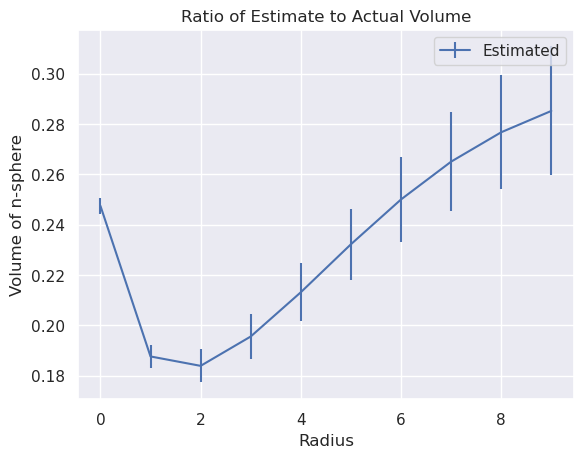

In [20]:
plot_array(heat_estimates/actual_volumes, "Ratio of Estimate to Actual Volume")

Here's the same experiment in higher dimensions.

In [21]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 3
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane")


KeyboardInterrupt: 

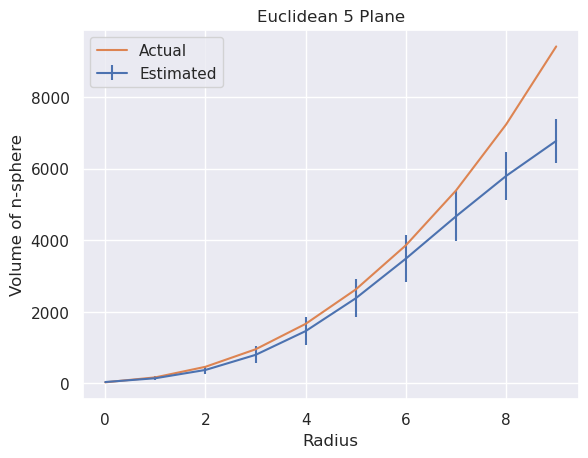

In [ ]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 5
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane")


Dimensions 3 and 5 behave as expected, displaying the same patterns of growing more unpredictable with age and varying from ground truth by some multiplicative factor.

With dimension 7, we begin to encounter the curse of dimensionality. 10,000 points is no longer enough; we need something on the order of a million to be able to diffuse for 10-20 steps without hitting edge effects.

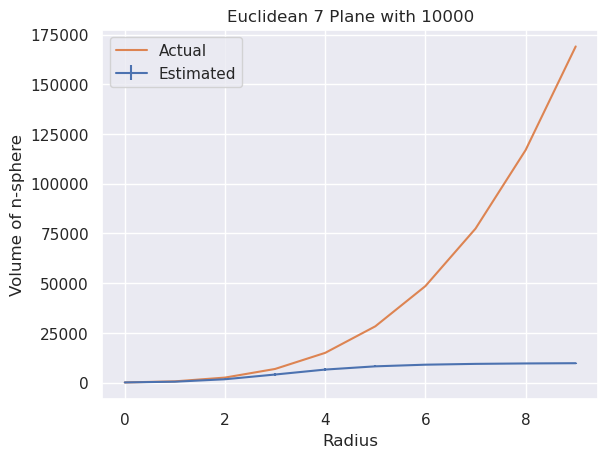

In [ ]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 7
n_points=10000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=10, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane with {n_points}")


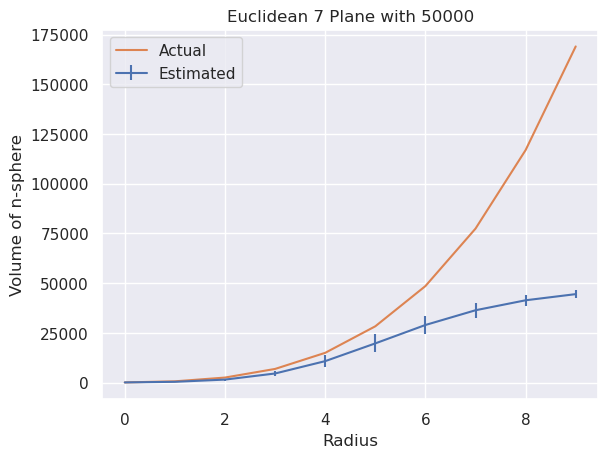

In [ ]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 7
n_points=50000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=10, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane with {n_points}")


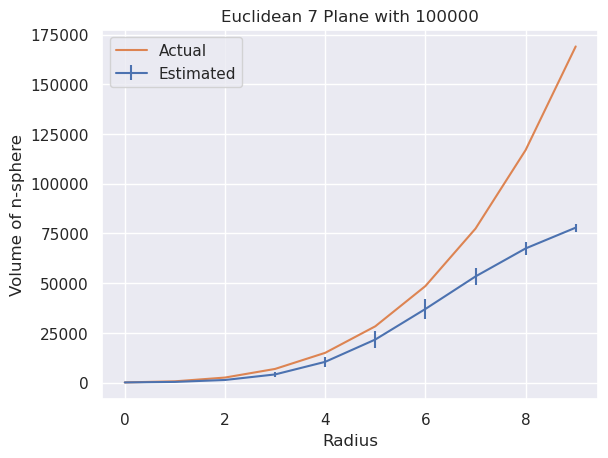

In [ ]:
ts = [2,4,6,8,10,12,14,16,18,20]
dim = 7
n_points=100000
radii = np.sqrt(ts)
heat_estimates = np.array(
    perform_trials(volumes_of_euclidean_nplane, n_trials=10, n_points=n_points, dim=dim, ts=ts)
)
actual_volumes = actual_euclidean_volumes_at_radii(dim,radii)
plot_arrays(heat_estimates,actual_volumes,title=f"Euclidean {dim} Plane with {n_points}")


## Does denoising reduce variation in volume measurements?
To test this, here's several plots of the same volume estimate, with different scales of denoising.

In [29]:
volume_estimates_with_denoising = []
for denoising_scale in tqdm([0,1,3,5,7,9,15]):
    volume_estimates_with_denoising.append({})
    volume_estimates_with_denoising[-1]['scale'] = denoising_scale
    volume_estimates_with_denoising[-1]['array'] = np.array(
        perform_trials(volumes_of_euclidean_nplane, n_trials=50, n_points=5000, dim=2, ts=[2,4,6,8,10,12,14,16,18,20], denoising_scale=denoising_scale)
    )

  0%|          | 0/7 [00:00<?, ?it/s]

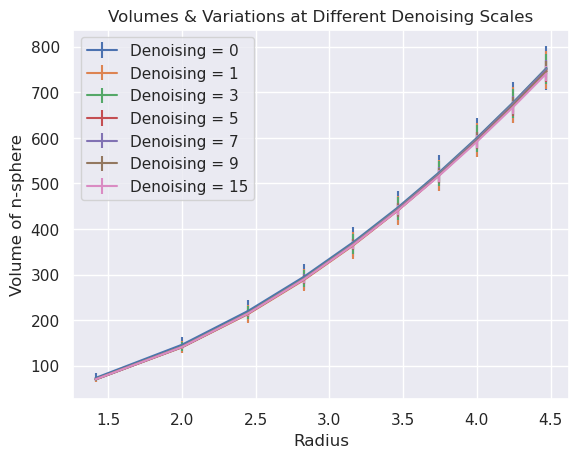

In [30]:
sns.set(style="darkgrid")  # Set the seaborn style
fig, ax = plt.subplots()
ts = [2,4,6,8,10,12,14,16,18,20]
xs = np.sqrt(ts)
for D in volume_estimates_with_denoising:
    # Compute the mean and standard deviation for the estimated array
    mean_estimated = np.mean(D['array'], axis=0)
    std_estimated = np.std(D['array'], axis=0)
    # Plot estimated as a line with error bars
    ax.errorbar(x = xs, y = mean_estimated, yerr=std_estimated, label=f"Denoising = {D['scale']}")
ax.set_xlabel("Radius")
ax.set_ylabel("Volume of n-sphere")
ax.set_title("Volumes & Variations at Different Denoising Scales")
ax.legend()
plt.show()